# Hipótesis de trabajo

In [1]:
# import libraries
import pandas as pd
from optimus import Optimus
op = Optimus()

In [2]:
# Read the data
# Data from http://rpubs.com/rhuebner/HRCodebook-13
df = op.read.csv("data/hr-data.csv", header=True)

In [3]:
# See the data
df.table()

Employee_Name 1 (string) nullable,EmpID 2 (string) nullable,MarriedID 3 (string) nullable,MaritalStatusID 4 (string) nullable,GenderID 5 (string) nullable,EmpStatusID 6 (string) nullable,DeptID 7 (string) nullable,PerfScoreID 8 (string) nullable,FromDiversityJobFairID 9 (string) nullable,PayRate 10 (string) nullable,Termd 11 (string) nullable,PositionID 12 (string) nullable,Position 13 (string) nullable,State 14 (string) nullable,Zip 15 (string) nullable,DOB 16 (string) nullable,Sex 17 (string) nullable,MaritalDesc 18 (string) nullable,CitizenDesc 19 (string) nullable,HispanicLatino 20 (string) nullable,RaceDesc 21 (string) nullable,DateofHire 22 (string) nullable,DateofTermination 23 (string) nullable,TermReason 24 (string) nullable,EmploymentStatus 25 (string) nullable,Department 26 (string) nullable,ManagerName 27 (string) nullable,ManagerID 28 (string) nullable,RecruitmentSource 29 (string) nullable,PerformanceScore 30 (string) nullable,EngagementSurvey 31 (string) nullable,EmpSatisfaction 32 (string) nullable,SpecialProjectsCount 33 (string) nullable,LastPerformanceReview_Date 34 (string) nullable,DaysLateLast30 35 (string) nullable
"Brown,⋅Mia",1103024456,1,1,0,1,1,3,1,28.50,0,1,Accountant⋅I,MA,01450,11/24/87,F,Married,US⋅Citizen,No,Black⋅or⋅African⋅American,10/27/2008,None,N/A⋅-⋅still⋅employed,Active,Admin⋅Offices,Brandon⋅R.⋅LeBlanc,1,Diversity⋅Job⋅Fair,Fully⋅Meets,2.04,2,6,1/15/2019,0
"LaRotonda,⋅William⋅⋅",1106026572,0,2,1,1,1,3,0,23.00,0,1,Accountant⋅I,MA,01460,04/26/84,M⋅,Divorced,US⋅Citizen,No,Black⋅or⋅African⋅American,1/6/2014,None,N/A⋅-⋅still⋅employed,Active,Admin⋅Offices,Brandon⋅R.⋅LeBlanc,1,Website⋅Banner⋅Ads,Fully⋅Meets,5.00,4,4,1/17/2019,0
"Steans,⋅Tyrone⋅⋅",1302053333,0,0,1,1,1,3,0,29.00,0,1,Accountant⋅I,MA,02703,09/01/86,M⋅,Single,US⋅Citizen,No,White,9/29/2014,None,N/A⋅-⋅still⋅employed,Active,Admin⋅Offices,Brandon⋅R.⋅LeBlanc,1,Internet⋅Search,Fully⋅Meets,3.90,5,5,1/18/2019,0
"Howard,⋅Estelle",1211050782,1,1,0,1,1,3,0,21.50,1,2,Administrative⋅Assistant,MA,02170,09/16/85,F,Married,US⋅Citizen,No,White,2/16/2015,04/15/15,None,Terminated⋅for⋅Cause,Admin⋅Offices,Brandon⋅R.⋅LeBlanc,1,Pay⋅Per⋅Click⋅-⋅Google,Fully⋅Meets,3.24,3,4,None,None
"Singh,⋅Nan⋅",1307059817,0,0,0,1,1,3,0,16.56,0,2,Administrative⋅Assistant,MA,02330,05/19/88,F,Single,US⋅Citizen,No,White,5/1/2015,None,N/A⋅-⋅still⋅employed,Active,Admin⋅Offices,Brandon⋅R.⋅LeBlanc,1,Website⋅Banner⋅Ads,Fully⋅Meets,5.00,3,5,1/15/2019,0
"Smith,⋅Leigh⋅Ann",711007713,1,1,0,5,1,3,1,20.50,1,2,Administrative⋅Assistant,MA,01844,06/14/87,F,Married,US⋅Citizen,No,Asian,9/26/2011,09/25/13,career⋅change,Voluntarily⋅Terminated,Admin⋅Offices,Brandon⋅R.⋅LeBlanc,1,Diversity⋅Job⋅Fair,Fully⋅Meets,3.80,4,4,None,None
"Bunbury,⋅Jessica",1504073368,1,1,0,5,6,3,0,55.00,1,3,Area⋅Sales⋅Manager,VA,21851,06/01/64,F,Married,Eligible⋅NonCitizen,No,Black⋅or⋅African⋅American,8/15/2011,08/02/14,Another⋅position,Voluntarily⋅Terminated,Sales,John⋅Smith,17,Social⋅Networks⋅-⋅Facebook⋅Twitter⋅etc,Fully⋅Meets,3.14,5,0,None,None
"Carter,⋅Michelle⋅",1403065721,0,0,0,1,6,3,0,55.00,0,3,Area⋅Sales⋅Manager,VT,05664,05/15/63,F,Single,US⋅Citizen,No,White,8/18/2014,None,N/A⋅-⋅still⋅employed,Active,Sales,John⋅Smith,17,Billboard,Fully⋅Meets,5.00,5,0,1/21/2019,0
"Dietrich,⋅Jenna⋅⋅",1408069481,0,0,0,1,6,1,0,55.00,0,3,Area⋅Sales⋅Manager,WA,98052,05/14/87,F,Single,US⋅Citizen,Yes,White,2/20/2012,None,N/A⋅-⋅still⋅employed,Active,Sales,John⋅Smith,17,Website⋅Banner⋅Ads,PIP,2.30,1,0,1/29/2019,0
"Digitale,⋅Alfred",1306059197,1,1,1,1,6,3,0,56.00,0,3,Area⋅Sales⋅Manager,NH,03062,09/14/88,M⋅,Married,US⋅Citizen,No,American⋅Indian⋅or⋅Alaska⋅Native,8/18/2014,None,N/A⋅-⋅still⋅employed,Active,Sales,John⋅Smith,17,Pay⋅Per⋅Click⋅-⋅Google,Fully⋅Meets,3.60,5,0,1/30/2019,0


In [7]:
# Basic data cleaning
from pyspark.sql.functions import when, count, col, isnull


integer_cols = ["MaritalStatusID", "EmpStatusID", "DeptID", "PerfScoreID", "PositionID", "Termd", "ManagerID", 
                "EmpSatisfaction", "SpecialProjectsCount", "DaysLateLast30"]
float_cols = ["PayRate", "EngagementSurvey"]

for col_name in integer_cols:
    df = df.withColumn(col_name, col(col_name).cast('int'))
    
for col_name in float_cols:
    df = df.withColumn(col_name, col(col_name).cast('float'))
    
df = df.dropna(how="all")
df = df.cols.years_between("DOB", date_format="mm/dd/yy",output_cols="Age")

In [23]:
import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

def count_to_pct(df, columns):
    return (df.groupBy(*columns, "Termd")
            .agg(F.count("Termd").alias("count_with_churn"))
            .orderBy('count_with_churn', ascending=False)
            .filter(col("Termd") == 1)
            .groupBy(*columns)
            .agg(F.sum("count_with_churn").alias("count"))
            .withColumn('total',F.sum("count").over(window))
            .withColumn('pct',F.round(col('count')/col('total'),2))
            .drop("total"))

## ¿Es un problema departamental?

In [13]:
df.groupby("Department").count().table()

Department 1 (string) nullable,count 2 (bigint) not nullable
Sales,31
Production⋅⋅⋅⋅⋅⋅⋅,208
Admin⋅Offices,10
Executive⋅Office,1
Software⋅Engineering,10
IT/IS,50


In [9]:
df.groupby("Department").sum("Termd").table()

Department 1 (string) nullable,sum(Termd) 2 (bigint) nullable
Sales,4
Production⋅⋅⋅⋅⋅⋅⋅,83
Admin⋅Offices,3
Executive⋅Office,0
Software⋅Engineering,3
IT/IS,10


In [26]:
count_to_pct(df, columns=["Department"]).table()

Department 1 (string) nullable,count 2 (bigint) nullable,pct 3 (double) nullable
Sales,4,0.04
Production⋅⋅⋅⋅⋅⋅⋅,83,0.81
Admin⋅Offices,3,0.03
Software⋅Engineering,3,0.03
IT/IS,10,0.1


## ¿Es un problema de estado civil?

In [14]:
df.groupby("MaritalDesc").count().table()

MaritalDesc 1 (string) nullable,count 2 (bigint) not nullable
Separated,12
Married,123
Divorced,30
Widowed,8
Single,137


In [11]:
df.groupby("MaritalDesc").sum("Termd").table()

MaritalDesc 1 (string) nullable,sum(Termd) 2 (bigint) nullable
Separated,1
Married,46
Divorced,16
Widowed,4
Single,36


In [27]:
count_to_pct(df, columns=["MaritalDesc"]).table()

MaritalDesc 1 (string) nullable,count 2 (bigint) nullable,pct 3 (double) nullable
Separated,1,0.01
Married,46,0.45
Divorced,16,0.16
Widowed,4,0.04
Single,36,0.35


## ¿Es un problema racial?

In [28]:
df.groupby("RaceDesc").count().table()

RaceDesc 1 (string) nullable,count 2 (bigint) not nullable
White,193
Two⋅or⋅more⋅races,18
Hispanic,4
Asian,34
Black⋅or⋅African⋅American,57
American⋅Indian⋅or⋅Alaska⋅Native,4


In [29]:
df.groupby("RaceDesc").sum("Termd").table()

RaceDesc 1 (string) nullable,sum(Termd) 2 (bigint) nullable
White,67
Two⋅or⋅more⋅races,7
Hispanic,1
Asian,11
Black⋅or⋅African⋅American,17
American⋅Indian⋅or⋅Alaska⋅Native,0


In [30]:
count_to_pct(df, columns=["RaceDesc"]).table()

RaceDesc 1 (string) nullable,count 2 (bigint) nullable,pct 3 (double) nullable
White,67,0.65
Two⋅or⋅more⋅races,7,0.07
Hispanic,1,0.01
Asian,11,0.11
Black⋅or⋅African⋅American,17,0.17


## ¿Es un problema de performance?

In [31]:
df.groupby("PerformanceScore").count().table()

PerformanceScore 1 (string) nullable,count 2 (bigint) not nullable
Needs⋅Improvement,18
Exceeds,37
Fully⋅Meets,243
PIP,12


In [32]:
df.groupby("PerformanceScore").sum("Termd").table()

PerformanceScore 1 (string) nullable,sum(Termd) 2 (bigint) nullable
Needs⋅Improvement,10
Exceeds,8
Fully⋅Meets,81
PIP,4


In [33]:
count_to_pct(df, columns=["PerformanceScore"]).table()

PerformanceScore 1 (string) nullable,count 2 (bigint) nullable,pct 3 (double) nullable
Needs⋅Improvement,10,0.1
Exceeds,8,0.08
Fully⋅Meets,81,0.79
PIP,4,0.04


## ¿Tendrá algo que ver con el manager?

In [55]:
count_to_pct(df, columns=["ManagerName"]).table(21)

ManagerName 1 (string) nullable,count 2 (bigint) nullable,pct 3 (double) nullable
Ketsia⋅Liebig,5,0.05
Michael⋅Albert,9,0.09
David⋅Stanley,6,0.06
Debra⋅Houlihan,1,0.01
Webster⋅Butler,13,0.13
Janet⋅King,6,0.06
Peter⋅Monroe,1,0.01
Simon⋅Roup,8,0.08
John⋅Smith,3,0.03
Elijiah⋅Gray,8,0.08


## ¿Es un problema de edad?

In [80]:
from pyspark.ml.feature import Bucketizer
splits = [10, 20, 30, 40, 50, 60, float("inf")]

bucketizer = Bucketizer(splits=splits, inputCol="Age", outputCol="Age_bucket")
df = bucketizer.transform(df)

In [85]:
df.groupby("Age_bucket").avg("Age").table()

Age_bucket 1 (double) nullable,avg(Age) 2 (double) nullable
1.0,28.983382138338957
4.0,53.52568329705132
3.0,44.680626421558614
2.0,34.91674258834437
5.0,65.64640778761644


In [81]:
df.groupby("Age_bucket").count().table()

Age_bucket 1 (double) nullable,count 2 (bigint) not nullable
1.0,11
4.0,36
3.0,98
2.0,152
5.0,13


In [83]:
df.groupby("Age_bucket").sum("Termd").table()

Age_bucket 1 (double) nullable,sum(Termd) 2 (bigint) nullable
1.0,2
4.0,10
3.0,34
2.0,49
5.0,8


In [84]:
count_to_pct(df, columns=["Age_bucket"]).table(21)

Age_bucket 1 (double) nullable,count 2 (bigint) nullable,pct 3 (double) nullable
1.0,2,0.02
4.0,10,0.1
3.0,34,0.33
2.0,49,0.48
5.0,8,0.08


### Estudio de correlación

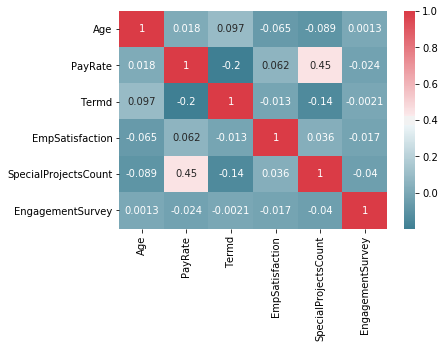

In [65]:
df.plot.correlation(["Age","PayRate","Termd", "EmpSatisfaction", "SpecialProjectsCount", "EngagementSurvey"])